# 1 Import Packages

In [1]:
import xarray as xr
import numpy as np
import os

import src.config as config
import src.utils as utils

import sklearn.linear_model
from tqdm import tqdm
import cartopy.crs as ccrs

import matplotlib.pyplot as plt

# 2 Metadata

In [2]:
ml_transform_path = os.path.join(config.data_pro_path,"ml_transform")

In [37]:
lev_index = 23

In [38]:
train_x_filename = "train_data_stack_lonlatstandardized.nc"
valid_x_filename = "valid_data_stack_lonlatstandardized.nc"

train_y_filename = "train_data_amoc_depth_1020_lat_26_samplestandardized.nc"
valid_y_filename = "valid_data_amoc_depth_1020_lat_26_samplestandardized.nc"

# 3 Load Data

In [39]:
train_x_xr = xr.open_dataset(os.path.join(ml_transform_path, train_x_filename)).isel(lev=lev_index)
valid_x_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_x_filename)).isel(lev=lev_index)

In [40]:
train_y_xr = xr.open_dataset(os.path.join(ml_transform_path, train_y_filename))
valid_y_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_y_filename))

In [41]:
train_data_amoc_depth_1020_lat_26_samplestd  = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplestd.nc" ))
train_data_amoc_depth_1020_lat_26_samplemean = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplemean,nc"))

# 4 Processing

In [42]:
train_x_xr_stack = train_x_xr.stack(sample=("realization","time")).stack(feature=("lon","lat"))
valid_x_xr_stack = valid_x_xr.stack(sample=("realization","time")).stack(feature=("lon","lat"))

feature_coords = train_x_xr_stack.feature
sample_coords = train_x_xr_stack.sample

train_x_xr_stack_dropna = train_x_xr_stack.dropna(dim="feature")
valid_x_xr_stack_dropna = valid_x_xr_stack.dropna(dim="feature")

feature_dropna_coords = train_x_xr_stack_dropna.feature

In [43]:
train_y_xr_stack = train_y_xr.stack(sample=("realization","time"))
valid_y_xr_stack = valid_y_xr.stack(sample=("realization","time"))


# 5 Model

In [44]:
valid_sample_coords = valid_y_xr_stack.sample
train_sample_coords = train_y_xr_stack.sample

feature_drop_coords = train_x_xr_stack_dropna.feature
feature_full_coords = train_x_xr_stack.feature 

train_x_ml_xr = train_x_xr_stack_dropna["rho"]
valid_x_ml_xr = valid_x_xr_stack_dropna["rho"]

train_y_ml_xr = train_y_xr_stack["atlantic_moc"]
valid_y_ml_xr = valid_y_xr_stack["atlantic_moc"]

train_y_true_ml_xr = train_y_xr_stack["atlantic_moc"]
valid_y_true_ml_xr = valid_y_xr_stack["atlantic_moc"]


In [45]:
def mse_xr(pred, true, sample_dim = "sample"):
    return np.square(pred - true).mean(dim=sample_dim)

## 5.1 Train

In [46]:
alpha_list = np.logspace(-1,5, 200)

In [47]:
train_mse_list = []
valid_mse_list = []


for i,alpha in tqdm(enumerate(alpha_list)): 
    
    model = sklearn.linear_model.Ridge(alpha = alpha)
    
    model.fit(train_x_ml_xr, train_y_ml_xr)
    
    model_coef_ml_xr = xr.DataArray(model.coef_, dims = ["feature"], coords ={"feature":feature_drop_coords} )
    model_coef_tmp,_ = xr.align(model_coef_ml_xr, feature_coords, join="outer")

    train_y_pred_ml_np = model.predict(train_x_ml_xr)
    valid_y_pred_ml_np = model.predict(valid_x_ml_xr)

    train_y_pred_ml_xr = xr.DataArray(train_y_pred_ml_np, dims= ["sample"], coords = {"sample": train_sample_coords, "alpha":alpha})
    valid_y_pred_ml_xr = xr.DataArray(valid_y_pred_ml_np, dims= ["sample"], coords = {"sample": valid_sample_coords, "alpha":alpha})


    train_mse_tmp = mse_xr(train_y_pred_ml_xr, train_y_true_ml_xr)
    valid_mse_tmp = mse_xr(valid_y_pred_ml_xr, valid_y_true_ml_xr)


    if i == 0: 
        model_coef = model_coef_tmp.assign_coords({"alpha": alpha})
        train_mse = train_mse_tmp.assign_coords({"alpha":alpha})
        valid_mse = valid_mse_tmp.assign_coords({"alpha":alpha})
        train_pred = train_y_pred_ml_xr.assign_coords({"alpha":alpha})
        valid_pred = valid_y_pred_ml_xr.assign_coords({"alpha":alpha})

    else:
        model_coef = xr.concat([model_coef, model_coef_tmp.assign_coords({"alpha":alpha})], dim="alpha")
        train_mse = xr.concat([train_mse, train_mse_tmp.assign_coords({"alpha":alpha})], dim="alpha")
        valid_mse = xr.concat([valid_mse, valid_mse_tmp.assign_coords({"alpha":alpha})], dim="alpha")
        train_pred = xr.concat([train_pred, train_y_pred_ml_xr.assign_coords({"alpha":alpha})], dim="alpha")
        valid_pred = xr.concat([valid_pred, valid_y_pred_ml_xr.assign_coords({"alpha":alpha})], dim="alpha")
        

    data = xr.merge([
        model_coef.rename("coefficients"),
        train_mse.rename("train_mse"), 
        valid_mse.rename("valid_mse"),
        valid_pred.rename("valid_pred"),
        train_pred.rename("train_pred"),
        ])


0it [00:00, ?it/s]/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.51681e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
1it [00:02,  2.17s/it]/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.70989e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
2it [00:04,  2.42s/it]/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.8259e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
3it [00:07,  2.67s/it]/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.p

## 5.2  Evaluation

In [63]:
alpha_index_top = (np.abs(data["train_mse"] -data["valid_mse"]).argmin())
alpha_top = data.alpha.isel(alpha=alpha_index_top)

In [64]:
data["train_mse"].sel(alpha=alpha_top)

<xarray.DataArray 'train_mse' ()>
array(0.46344983)
Coordinates:
    alpha    float64 5.805e+03
    depth_2  float64 1.02e+03

In [65]:
data["valid_mse"].sel(alpha=alpha_top)

<xarray.DataArray 'valid_mse' ()>
array(0.46356914)
Coordinates:
    alpha    float64 5.805e+03
    depth_2  float64 1.02e+03

In [66]:
diff = data["train_mse"] - data["valid_mse"]

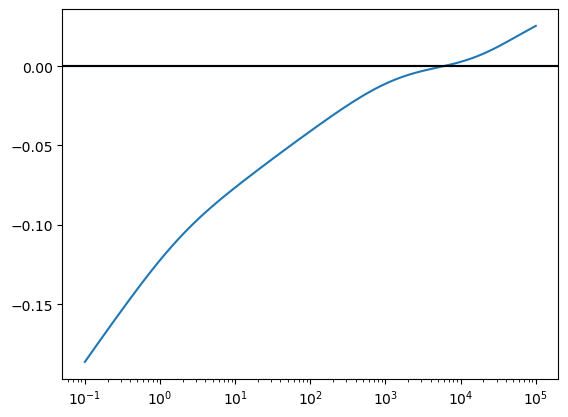

In [67]:
plt.plot(diff.alpha, diff)
plt.xscale("log")
plt.axhline()
plt.axhline(0, color="black")

In [68]:
alpha_top =  data["alpha"].isel(alpha=(np.abs(data["train_mse"] -data["valid_mse"]).argmin()))

In [69]:
train_corr = xr.corr(train_y_true_ml_xr, data["train_pred"], dim="sample")
valid_corr = xr.corr(valid_y_true_ml_xr, data["valid_pred"], dim="sample")


(0.0, 100.0)

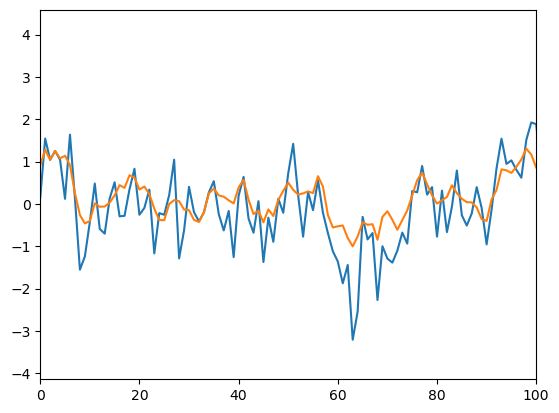

In [70]:
plt.plot(train_y_true_ml_xr)
plt.plot(data["train_pred"].sel(alpha=alpha_top))
plt.xlim(0,100)

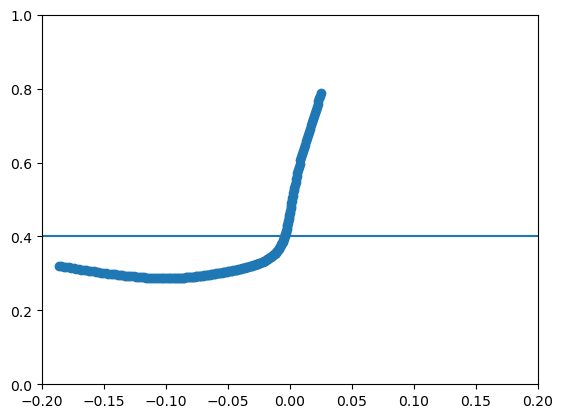

In [71]:
plt.scatter(data["train_mse"] -data["valid_mse"], data["valid_mse"])
plt.ylim(0,1)
plt.xlim(-0.2,0.2)
plt.axhline(0.4)

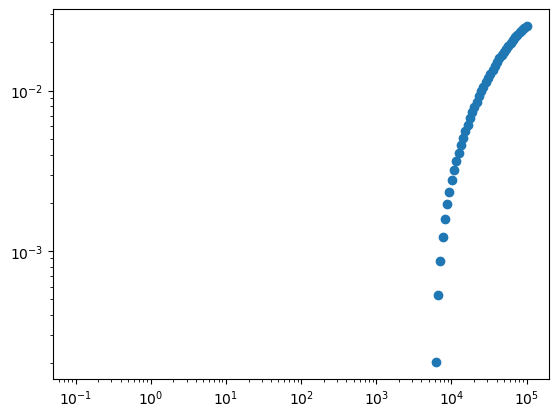

In [72]:
plt.scatter(data.alpha, data["train_mse"] -data["valid_mse"])
plt.xscale("log")
plt.yscale("log")

Text(0, 0.5, 'Error')

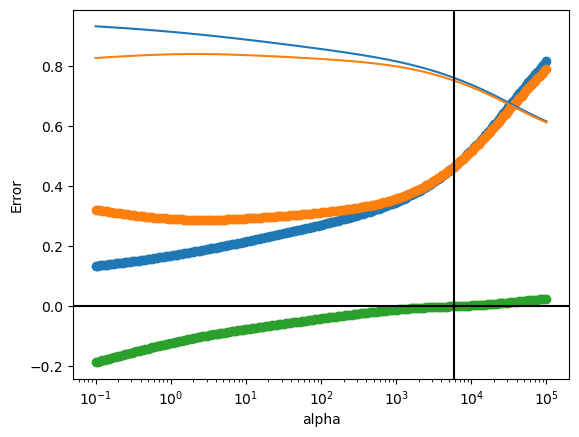

In [73]:
plt.scatter(data.alpha, data["train_mse"])
plt.scatter(data.alpha, data["valid_mse"])
plt.plot(data.alpha, train_corr)
plt.plot(data.alpha, valid_corr)
plt.scatter(data.alpha, data["train_mse"] -data["valid_mse"])
plt.xscale("log")

plt.axhline(0, color="black")
plt.axvline(alpha_top.values.item(), color="black")

plt.xlabel("alpha")
plt.ylabel("Error")



In [74]:
coefficients = data["coefficients"].unstack()

In [75]:
alpha_min = data.alpha.min()
alpha_max = data.alpha.max()


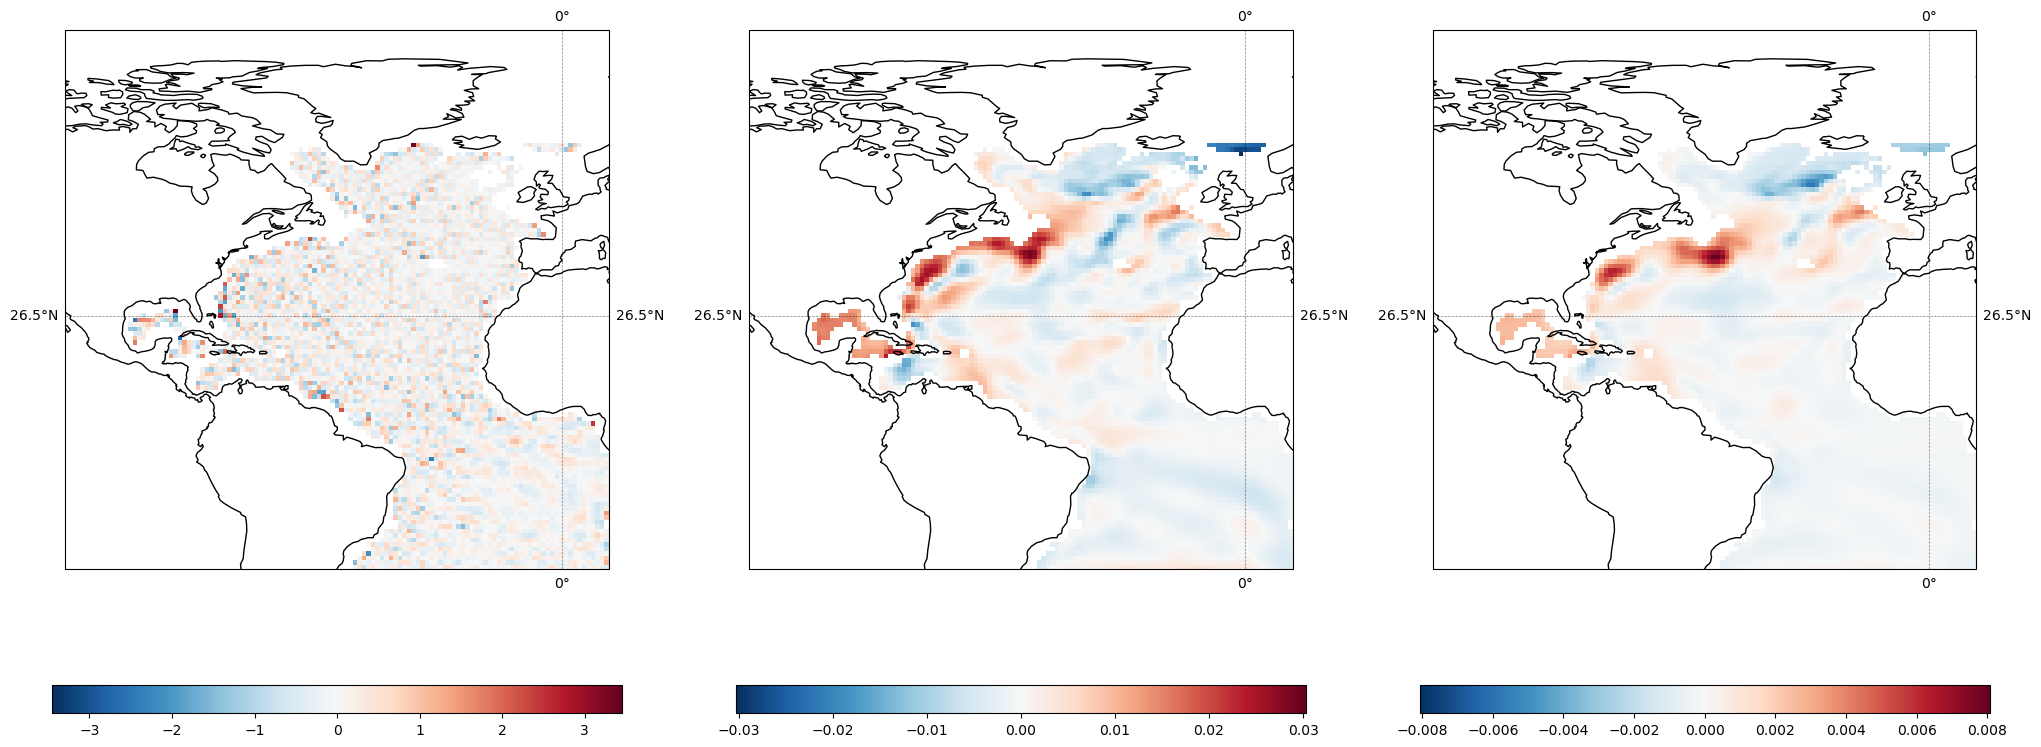

In [76]:
fig, ax  = plt.subplots(1,3,figsize=(25,10), subplot_kw = {"projection":ccrs.PlateCarree()})

ax_ravel = np.ravel(ax)


tmp = coefficients.sel(alpha=alpha_min)
vmax = np.abs(tmp).max()
plot = ax[0].pcolormesh(coefficients.lon, coefficients.lat, coefficients.sel(alpha=alpha_min).transpose("lat","lon"), vmin=-vmax, vmax= vmax,cmap="RdBu_r", transform=ccrs.PlateCarree())
plt.colorbar(plot, ax = ax[0], orientation="horizontal")

tmp = coefficients.sel(alpha=alpha_top)
vmax = np.abs(tmp).max()
plot = ax[1].pcolormesh(coefficients.lon, coefficients.lat, coefficients.sel(alpha=alpha_top).transpose("lat","lon"), vmin=-vmax, vmax=vmax, cmap="RdBu_r", transform=ccrs.PlateCarree())
plt.colorbar(plot, ax = ax[1], orientation="horizontal")

tmp = coefficients.sel(alpha=alpha_max)
vmax = np.abs(tmp).max()
plot = ax[2].pcolormesh(coefficients.lon, coefficients.lat, coefficients.sel(alpha=alpha_max).transpose("lat","lon"), vmin=-vmax, vmax=vmax,cmap="RdBu_r", transform=ccrs.PlateCarree())
plt.colorbar(plot, ax = ax[2], orientation="horizontal")






for i, ax in enumerate(ax_ravel):
    ax.coastlines()
    ax.gridlines(xlocs=[0], ylocs = [26.5], draw_labels=True, linewidth=0.5, color='k', alpha=0.5, linestyle='--')

